In [16]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

In [9]:
path = 'dataset_corrected/'
x1_train = pd.read_csv(path+'c_data_x1_train.csv')
x2_train = pd.read_csv(path+'c_data_x2_train.csv')
f1_train = pd.read_csv(path+'c_data_f1_train.csv')
f1_test = pd.read_csv(path+'c_data_f1_test.csv')
x1_test = pd.read_csv(path+'c_data_x1_test.csv')
x2_test = pd.read_csv(path+'c_data_x2_test.csv')

X_train = pd.DataFrame(data = np.concatenate((x1_train,x2_train),axis=1))
X_test = pd.DataFrame(data = np.concatenate((x1_test,x2_test),axis=1))
X_train.head()

,0,1
0,-0.0000,-0.0000
1,-0.0159,-0.0000
2,-0.0159,0.0171
3,-0.0159,0.0171
4,-0.0000,0.0329


In [10]:
from scipy import *
from scipy.linalg import norm, pinv
import math
 
from matplotlib import pyplot as plt
 
class RBF:
     
    def __init__(self, indim, numCenters, outdim):
        self.indim = indim
        self.outdim = outdim
        self.numCenters = numCenters
        self.centers = [np.random.uniform(-1, 1, indim) for i in range(numCenters)]
        self.beta = 8
        self.W = np.random.random((self.numCenters, self.outdim))
         
    def _basisfunc(self, c, d):
        assert len(d) == self.indim
        return norm(c-d)**3
     
    def _calcAct(self, X):
        # calculate activations of RBFs
        G = np.zeros((X.shape[0], self.numCenters), float)
        for ci, c in enumerate(self.centers):
            for xi, x in enumerate(X):
                G[xi,ci] = self._basisfunc(c, x)
        return G
     
    def train(self, X, Y):
        """ X: matrix of dimensions n x indim 
            y: column vector of dimension n x 1 """
         
        # choose random center vectors from training set
        rnd_idx = np.random.permutation(X.shape[0])[:self.numCenters]
        self.centers = [X[i,:] for i in rnd_idx]
         
        #print("center", self.centers)
        # calculate activations of RBFs
        G = self._calcAct(X)
        #print(G)
         
        # calculate output weights (pseudoinverse)
        self.W = np.dot(pinv(G), Y)
         
    def test(self, X):
        """ X: matrix of dimensions n x indim """
         
        G = self._calcAct(X)
        Y = np.dot(G, self.W)
        return Y

In [17]:
def get_results(t,m):
    l1 = len(X_train)
    l2 = len(X_test)
    x_train = [[0 for _ in range(m*2)] for _ in range(l1-t*(m-1))]
    x_test = [[0 for _ in range(m*2)] for _ in range(l2-t*(m-1))]

    for i in range(l1-t*(m-1)):
        for j in range(m):
            x_train[i][j]=X_train.iloc[t*(m-1)+i-2*j,0]
            x_train[i][j+m]=X_train.iloc[t*(m-1)+i-2*j,1]

    y_train = f1_train.iloc[t*(m-1):]

    for i in range(l2-t*(m-1)):
        for j in range(m):
            x_test[i][j]=X_test.iloc[t*(m-1)+i-2*j,0]
            x_test[i][j+m]=X_test.iloc[t*(m-1)+i-2*j,1]
    y_test = f1_test.iloc[t*(m-1):]
    x_train,x_test = np.array(x_train),np.array(x_test)
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    
    t1 = datetime.now()
    rf = RandomForestRegressor()
    rf.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Random Forest',t2-t1)
    
    y1_pred = rf.predict(x_test)
    y1 = y1_pred
    print('Root Mean Squared error of Random Forest',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error = []
    for i in range(len(y_test)):
        error.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error))
    print('Maximum Error =',max(error))
    error1 = sorted(error)
    print('Median Value of Error =',error1[len(error)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y1[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # RBF MODEL
    rbf = RBF(2*m, 100, 1)
    t1 = datetime.now()
    rbf.train(x_train, y_train)
    t2 = datetime.now()
    
    print('\n\nTime taken by RBF Model: ',t2-t1)
    y1_pred = rbf.test(x_test)
    y2 = y1_pred
    print('Root mean square error of RBF Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    
    error5 = []
    for i in range(len(y_test)):
        error5.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error5))
    print('Maximum Error =',max(error5))
    error6 = sorted(error5)
    print('Median Value of Error =',error6[len(error5)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y2[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    
    # GRADIENT BOOSTING
    gb = GradientBoostingRegressor()
    t1 = datetime.now()
    gb.fit(x_train,y_train)
    t2 = datetime.now()
    print('Time taken by Gradient Boosting:',t2-t1)

    y1_pred = gb.predict(x_test)
    print('Root mean square error of Gradient Boosting Model: ',sqrt(mean_squared_error(y_test,y1_pred)))
    y3 = y1_pred

    error9 = []
    for i in range(len(y_test)):
        error9.append(abs(y1_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error9))
    print('Maximum Error =',max(error9))
    error8 = sorted(error9)
    print('Median Value of Error =',error8[len(error9)//2])

    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y3[:6000], label = 'Gradient Boosting')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()

    
    # closer view at initial points
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error9[:6000], label = 'Gradient Boosting')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()
    
    # CatBoost model
    cat = CatBoostRegressor()
    t1 = datetime.now()
    cat.fit(x_train,y_train)
    t2 = datetime.now()
    print('\n\n\nTime taken by Cat Boosting:',t2-t1)

    y_pred = cat.predict(x_test)
    print('Root mean square error of Cat Boost Model: ',sqrt(mean_squared_error(y_test,y_pred)))
    
    error_cat = []
    for i in range(len(y_test)):
        error_cat.append(abs(y_pred[i]-y_test.iloc[i,0]))
    print('Minimum Error =',min(error_cat))
    print('Maximum Error =',max(error_cat))
    error8 = sorted(error_cat)
    print('Median Value of Error =',error8[len(error8)//2])
    
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),y_pred[:6000], label = 'Cat Boost')
    plt.plot(list(range(6000)),y_test[:6000], label = 'Actual')
    plt.legend()
    plt.xlabel('Time (in ms)')
    plt.ylabel('Force')
    plt.title('Models prediction comparison')
    plt.show()
    
    # Error plots
    plt.figure(figsize=(20,5))
    plt.plot(list(range(6000)),error5[:6000], label = 'RBF Model')
    plt.plot(list(range(6000)),error[:6000], label = 'Random Forest')
    plt.plot(list(range(6000)),error9[:6000], label = 'Gradient Boosting Model')
    plt.plot(list(range(6000)),error_cat[:6000], label = 'Cat Boosting Model')
    plt.legend()
    plt.title('Error as a function of time')
    plt.show()

# Results

Time taken by Random Forest 0:01:51.566081
Root Mean Squared error of Random Forest 0.06172756436649802
Minimum Error = 9.999999996956888e-07
Maximum Error = 0.893903000000001
Median Value of Error = 0.02060800000000007


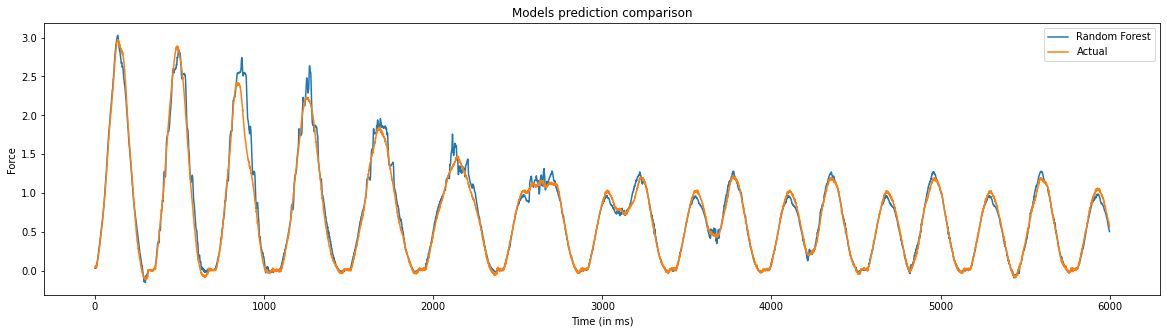



Time taken by RBF Model:  0:01:54.562947
Root mean square error of RBF Model:  0.04519471821318673
Minimum Error = [2.18768583e-07]
Maximum Error = [0.75688685]
Median Value of Error = [0.02071062]


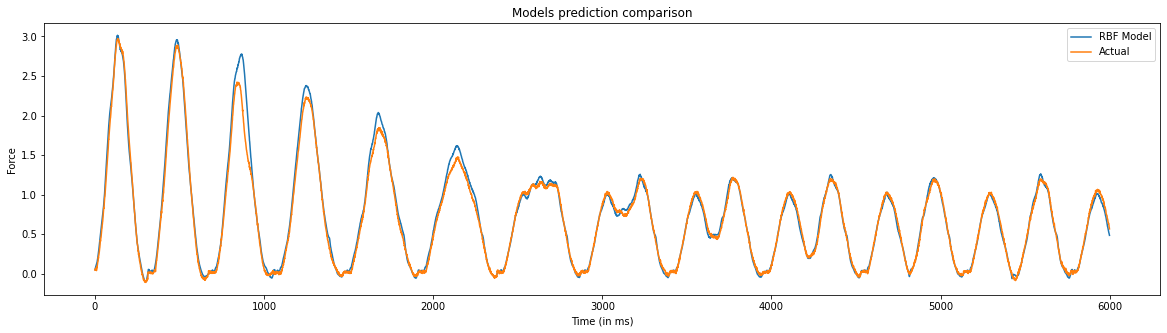

Time taken by Gradient Boosting: 0:00:35.307921
Root mean square error of Gradient Boosting Model:  0.0658973757296772
Minimum Error = 4.103261493311472e-06
Maximum Error = 1.091803106282064
Median Value of Error = 0.031213687901239462


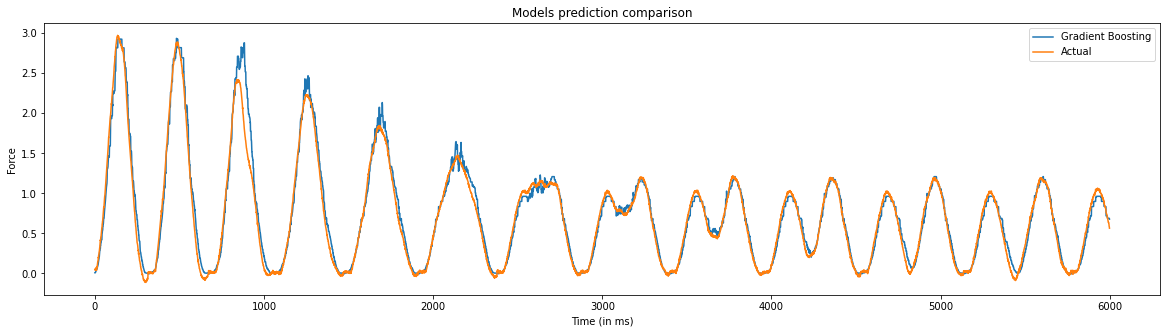

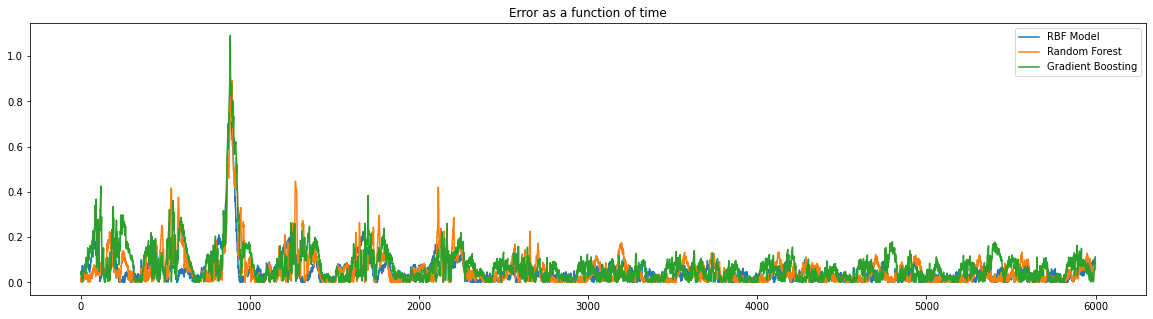

Learning rate set to 0.08682
0:	learn: 0.9230278	total: 12ms	remaining: 12s
1:	learn: 0.8475018	total: 17.7ms	remaining: 8.82s
2:	learn: 0.7784170	total: 22.6ms	remaining: 7.52s
3:	learn: 0.7149872	total: 28.5ms	remaining: 7.1s
4:	learn: 0.6572514	total: 34ms	remaining: 6.76s
5:	learn: 0.6051038	total: 39.6ms	remaining: 6.56s
6:	learn: 0.5565667	total: 45.9ms	remaining: 6.51s
7:	learn: 0.5121494	total: 51.5ms	remaining: 6.39s
8:	learn: 0.4716580	total: 57.6ms	remaining: 6.34s
9:	learn: 0.4346903	total: 62.8ms	remaining: 6.22s
10:	learn: 0.4014555	total: 68.1ms	remaining: 6.13s
11:	learn: 0.3708109	total: 73ms	remaining: 6.01s
12:	learn: 0.3430031	total: 78ms	remaining: 5.92s
13:	learn: 0.3174651	total: 83.4ms	remaining: 5.87s
14:	learn: 0.2946413	total: 89.1ms	remaining: 5.85s
15:	learn: 0.2734802	total: 94.6ms	remaining: 5.82s
16:	learn: 0.2540525	total: 103ms	remaining: 5.98s
17:	learn: 0.2370674	total: 109ms	remaining: 5.93s
18:	learn: 0.2215229	total: 114ms	remaining: 5.89s
19:	lea

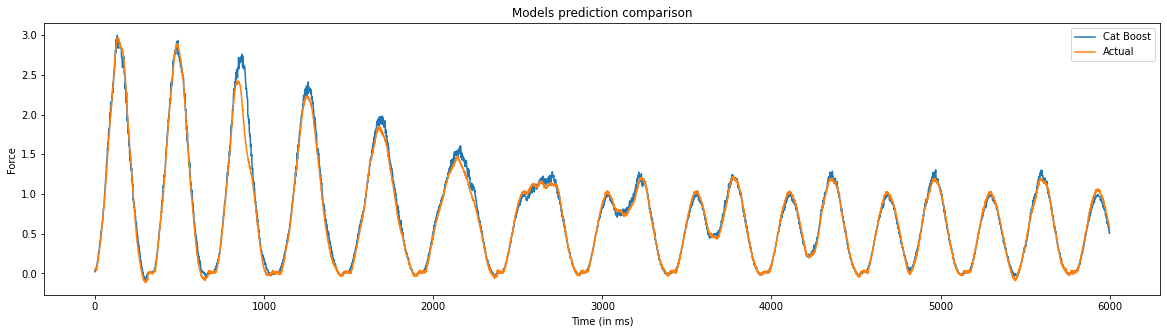

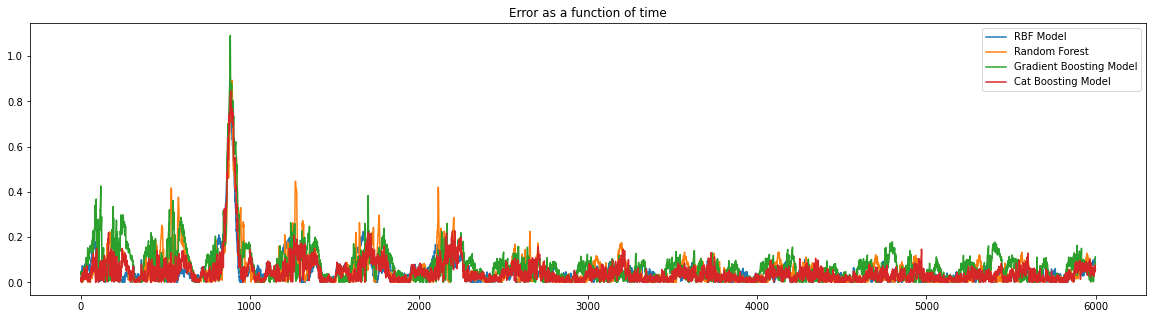

In [18]:
get_results(t=4,m=5)

Time taken by Random Forest 0:01:29.448925
Root Mean Squared error of Random Forest 0.06281260207533697
Minimum Error = 1.734723475976807e-18
Maximum Error = 0.9039800000000027
Median Value of Error = 0.020684999999999978


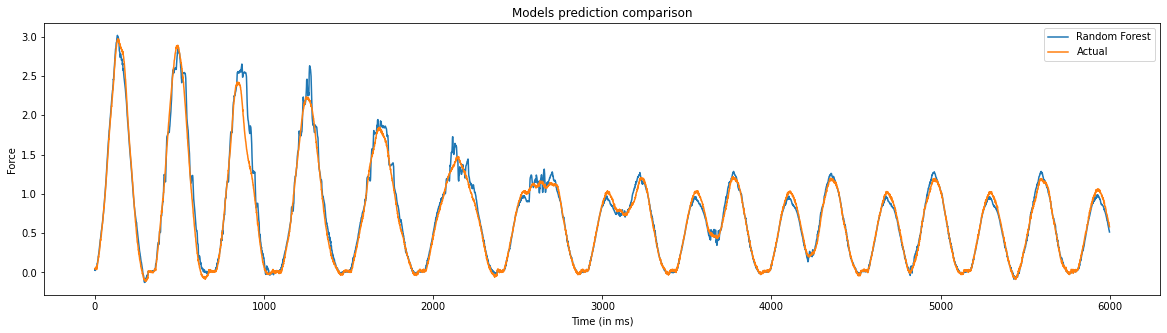



Time taken by RBF Model:  0:01:45.674030
Root mean square error of RBF Model:  0.05077631102452437
Minimum Error = [2.52114265e-08]
Maximum Error = [0.66730064]
Median Value of Error = [0.02145158]


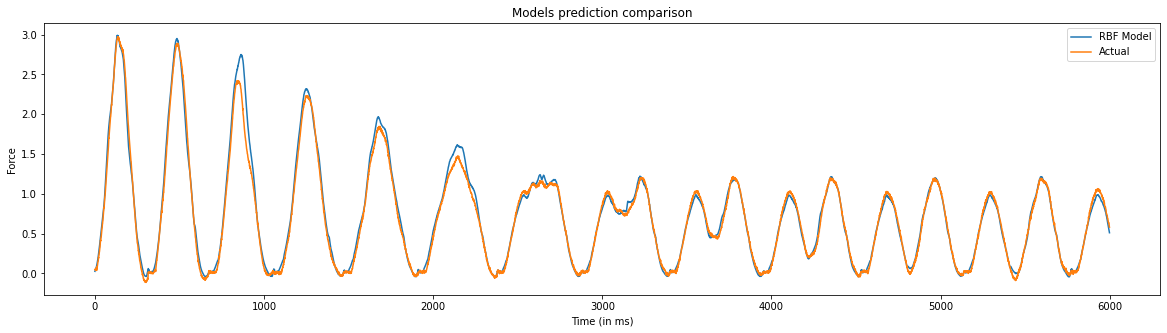

Time taken by Gradient Boosting: 0:00:28.785808
Root mean square error of Gradient Boosting Model:  0.06655414780497433
Minimum Error = 8.060044618361795e-08
Maximum Error = 0.9693193078841231
Median Value of Error = 0.030920684728668046


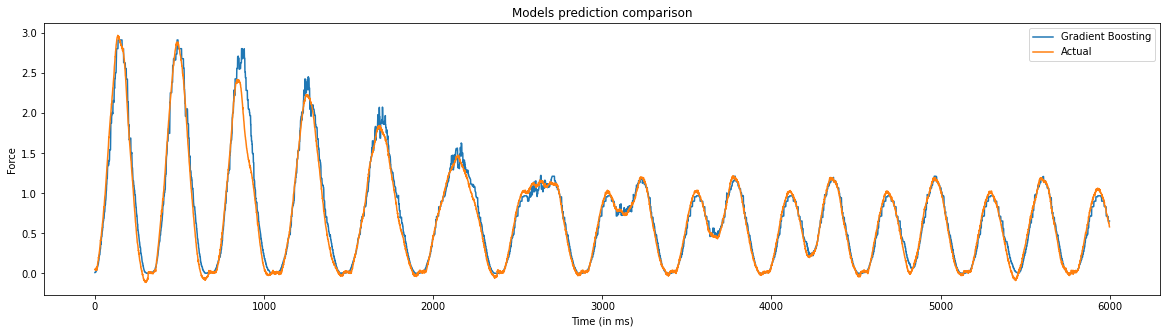

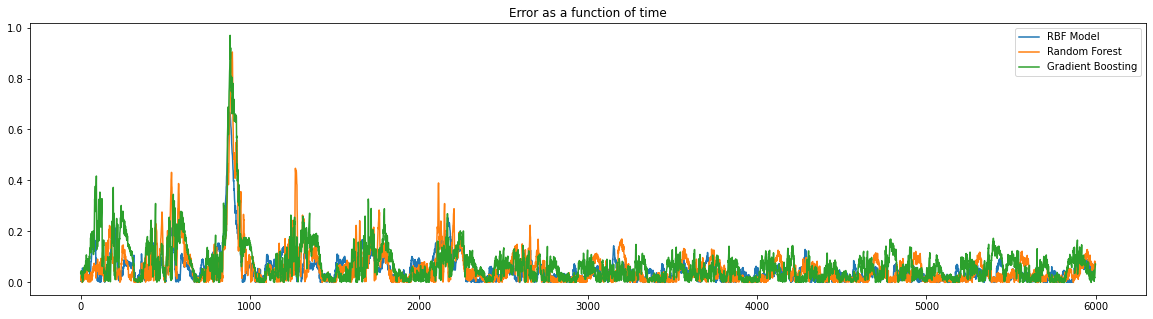

Learning rate set to 0.08682
0:	learn: 0.9237199	total: 9.47ms	remaining: 9.46s
1:	learn: 0.8479172	total: 15.3ms	remaining: 7.61s
2:	learn: 0.7784135	total: 20.4ms	remaining: 6.79s
3:	learn: 0.7151262	total: 25.3ms	remaining: 6.29s
4:	learn: 0.6568995	total: 32.1ms	remaining: 6.4s
5:	learn: 0.6039073	total: 36.9ms	remaining: 6.11s
6:	learn: 0.5556850	total: 41.6ms	remaining: 5.9s
7:	learn: 0.5114829	total: 48.2ms	remaining: 5.98s
8:	learn: 0.4713987	total: 52.8ms	remaining: 5.81s
9:	learn: 0.4344154	total: 57.5ms	remaining: 5.69s
10:	learn: 0.4007158	total: 62.3ms	remaining: 5.6s
11:	learn: 0.3698710	total: 66.9ms	remaining: 5.5s
12:	learn: 0.3422952	total: 71.7ms	remaining: 5.44s
13:	learn: 0.3164607	total: 76.8ms	remaining: 5.41s
14:	learn: 0.2932436	total: 81.8ms	remaining: 5.37s
15:	learn: 0.2723516	total: 86.6ms	remaining: 5.32s
16:	learn: 0.2529180	total: 91.5ms	remaining: 5.29s
17:	learn: 0.2354151	total: 95.9ms	remaining: 5.23s
18:	learn: 0.2195531	total: 101ms	remaining: 5.21

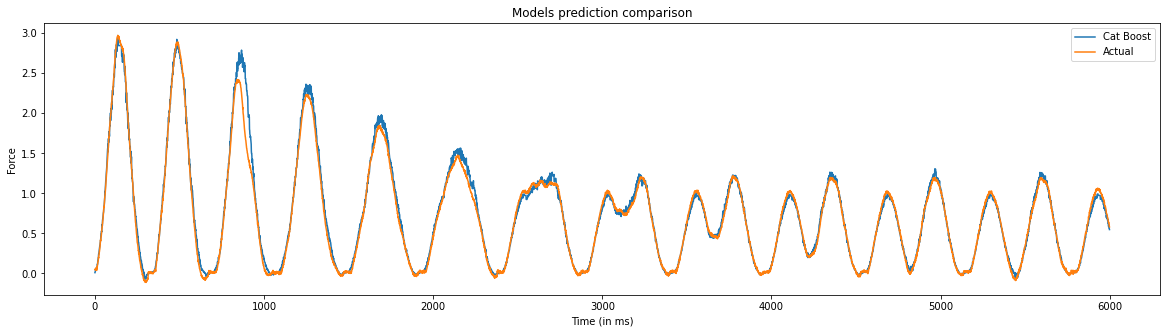

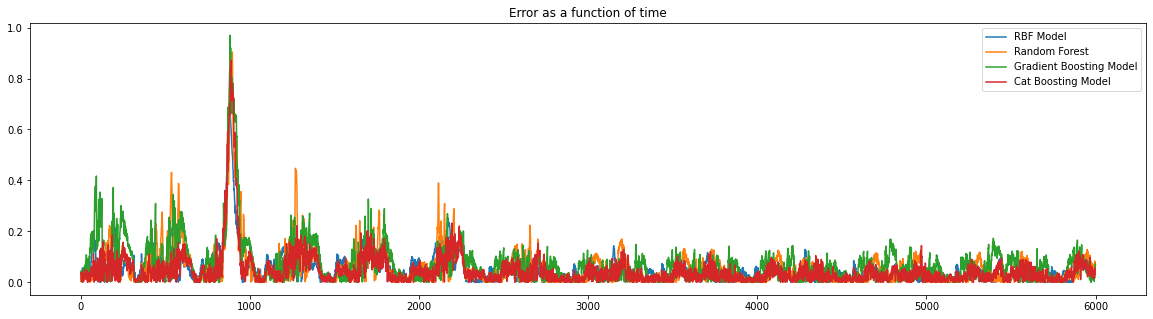

In [19]:
get_results(t=5,m=4)

Time taken by Random Forest 0:01:12.932365
Root Mean Squared error of Random Forest 0.06332105622762976
Minimum Error = 4.0000000000456337e-07
Maximum Error = 0.9328670000000014
Median Value of Error = 0.021170000000000355


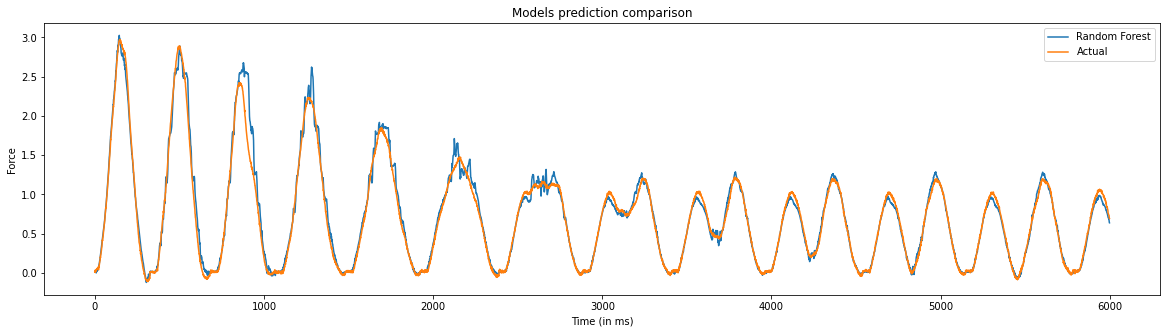



Time taken by RBF Model:  0:01:57.788092
Root mean square error of RBF Model:  0.04720189811120038
Minimum Error = [7.96031646e-07]
Maximum Error = [0.67637665]
Median Value of Error = [0.02148429]


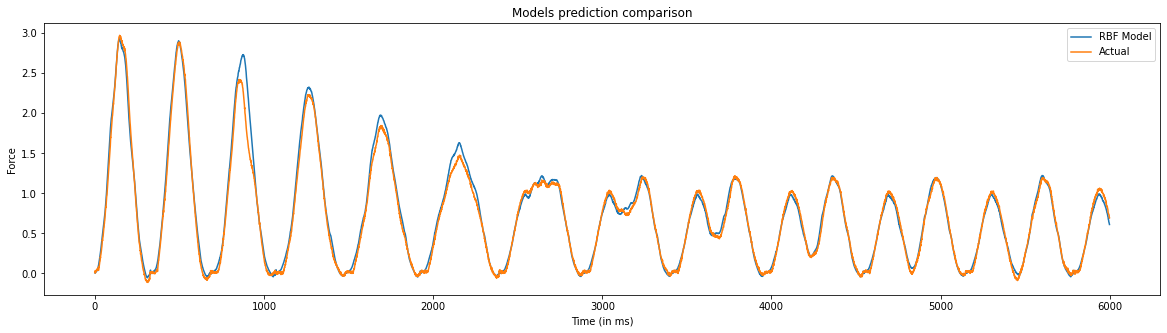

Time taken by Gradient Boosting: 0:00:21.169659
Root mean square error of Gradient Boosting Model:  0.06518032702060733
Minimum Error = 2.7263279887314307e-06
Maximum Error = 0.9868062891652207
Median Value of Error = 0.03166252820168708


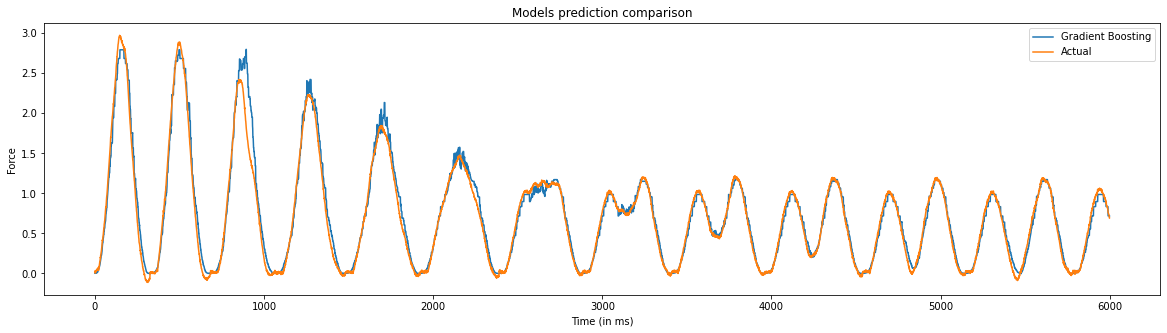

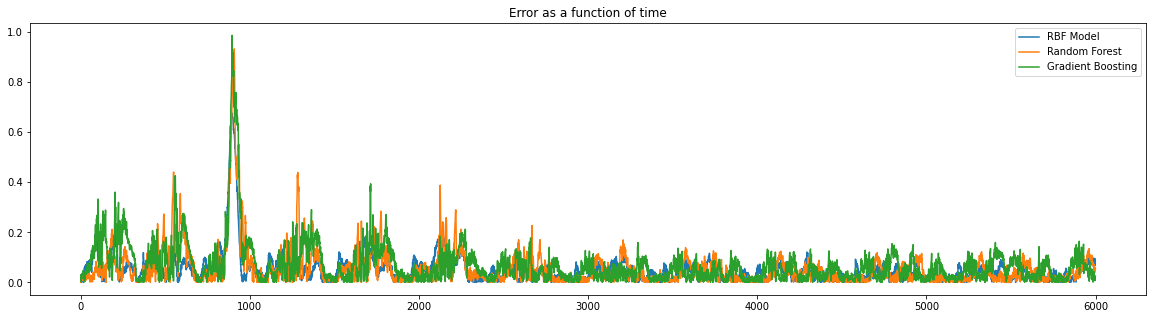

Learning rate set to 0.086821
0:	learn: 0.9231305	total: 14.4ms	remaining: 14.4s
1:	learn: 0.8476911	total: 19.8ms	remaining: 9.86s
2:	learn: 0.7782579	total: 27ms	remaining: 8.99s
3:	learn: 0.7145766	total: 32.5ms	remaining: 8.1s
4:	learn: 0.6565726	total: 38ms	remaining: 7.55s
5:	learn: 0.6036137	total: 43.3ms	remaining: 7.18s
6:	learn: 0.5558235	total: 48.4ms	remaining: 6.87s
7:	learn: 0.5116814	total: 53.6ms	remaining: 6.64s
8:	learn: 0.4710662	total: 58.8ms	remaining: 6.47s
9:	learn: 0.4340312	total: 63.7ms	remaining: 6.31s
10:	learn: 0.4004448	total: 68.8ms	remaining: 6.18s
11:	learn: 0.3698270	total: 74.4ms	remaining: 6.12s
12:	learn: 0.3419533	total: 79.4ms	remaining: 6.03s
13:	learn: 0.3164474	total: 84.6ms	remaining: 5.96s
14:	learn: 0.2925974	total: 89.3ms	remaining: 5.87s
15:	learn: 0.2710270	total: 94.4ms	remaining: 5.8s
16:	learn: 0.2516707	total: 99.1ms	remaining: 5.73s
17:	learn: 0.2341890	total: 104ms	remaining: 5.68s
18:	learn: 0.2182648	total: 109ms	remaining: 5.64s


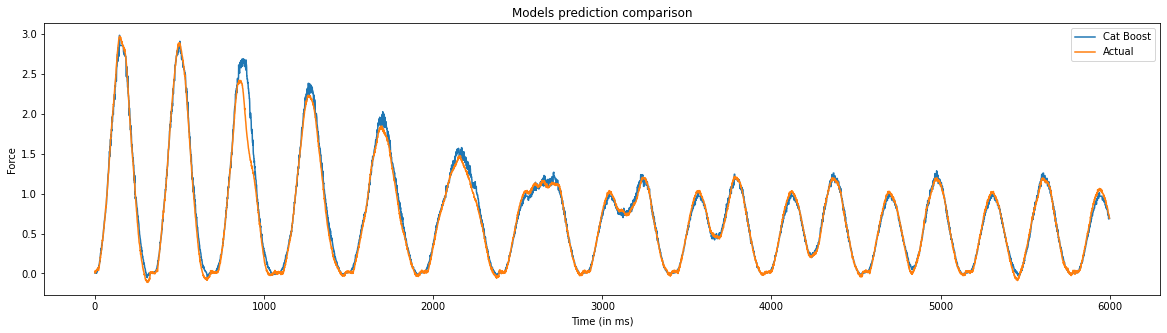

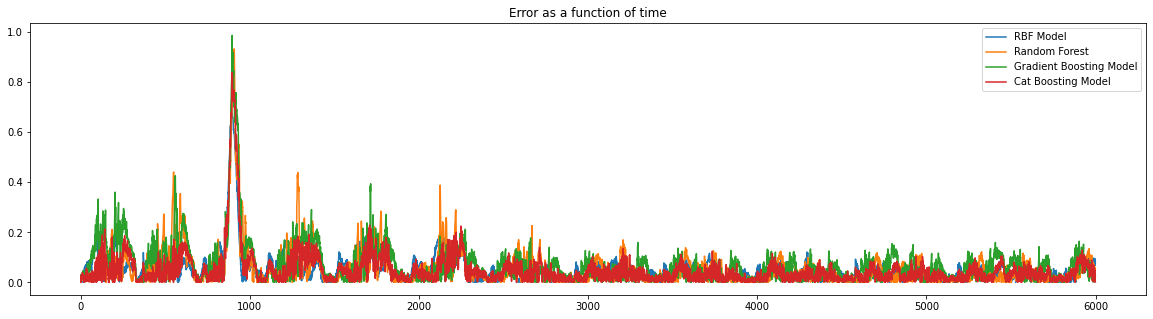

In [20]:
get_results(t=2,m=3)

Time taken by Random Forest 0:00:48.792481
Root Mean Squared error of Random Forest 0.0641903256064394
Minimum Error = 2.220446049250313e-16
Maximum Error = 0.9302900000000001
Median Value of Error = 0.021831000000000045


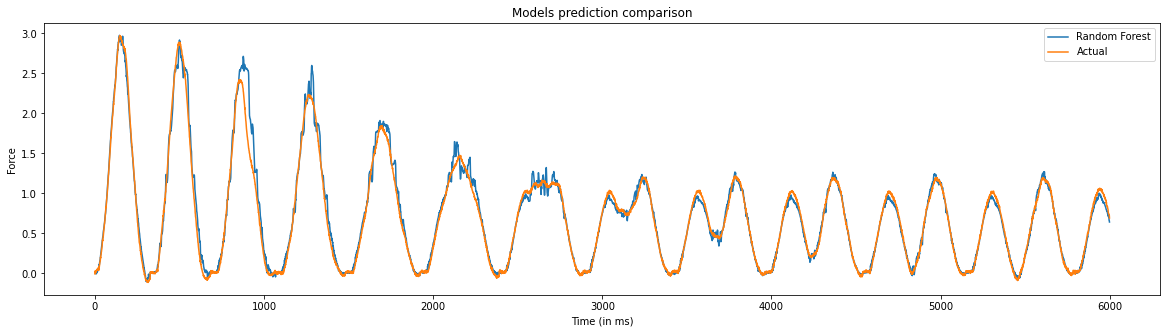



Time taken by RBF Model:  0:02:11.696694
Root mean square error of RBF Model:  0.04396518118869127
Minimum Error = [3.44661357e-07]
Maximum Error = [0.6983076]
Median Value of Error = [0.02178254]


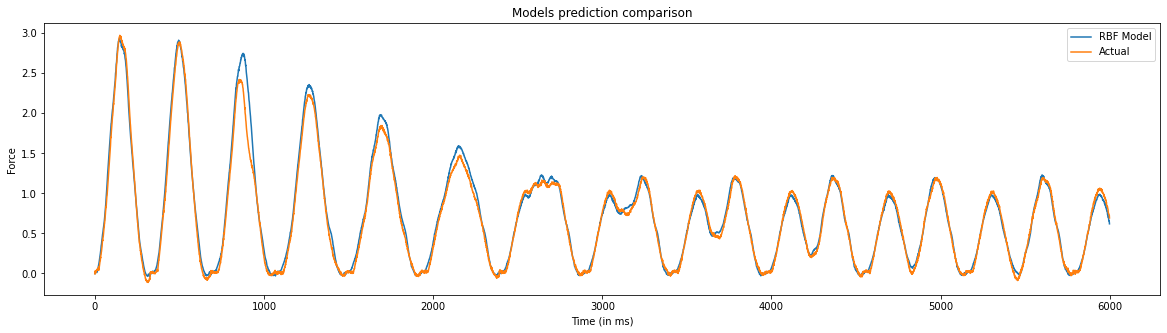

Time taken by Gradient Boosting: 0:00:14.455037
Root mean square error of Gradient Boosting Model:  0.06741441649773594
Minimum Error = 3.658750722789622e-08
Maximum Error = 0.9301860736182683
Median Value of Error = 0.0319576771799697


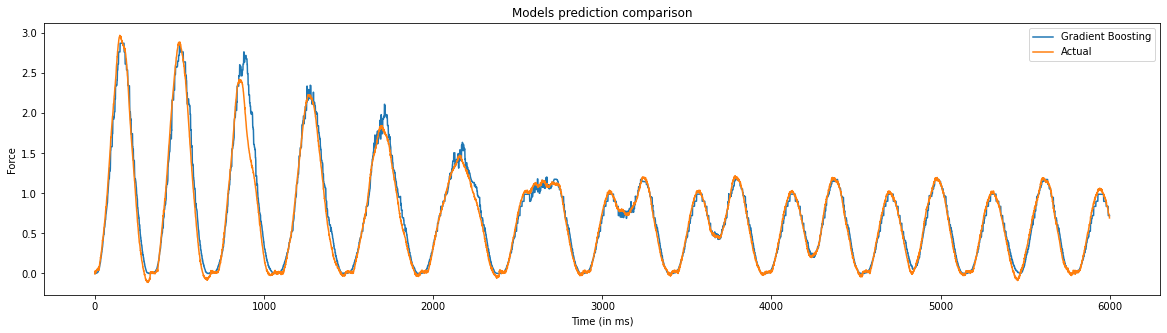

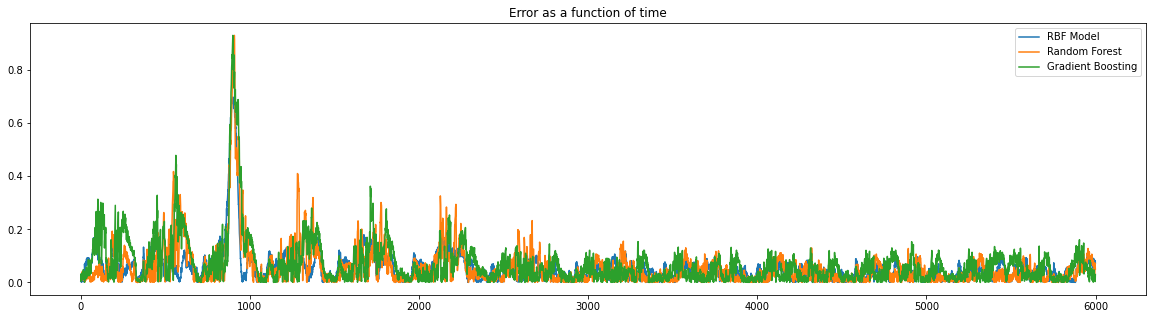

Learning rate set to 0.086821
0:	learn: 0.9230022	total: 10.1ms	remaining: 10.1s
1:	learn: 0.8474529	total: 17ms	remaining: 8.48s
2:	learn: 0.7780512	total: 22.6ms	remaining: 7.52s
3:	learn: 0.7151478	total: 28.1ms	remaining: 7s
4:	learn: 0.6573463	total: 33.7ms	remaining: 6.71s
5:	learn: 0.6042047	total: 39.7ms	remaining: 6.58s
6:	learn: 0.5555084	total: 52ms	remaining: 7.38s
7:	learn: 0.5112878	total: 58.1ms	remaining: 7.2s
8:	learn: 0.4708492	total: 63.3ms	remaining: 6.97s
9:	learn: 0.4338065	total: 73.6ms	remaining: 7.29s
10:	learn: 0.4002020	total: 79.5ms	remaining: 7.15s
11:	learn: 0.3691562	total: 88.5ms	remaining: 7.29s
12:	learn: 0.3410585	total: 113ms	remaining: 8.6s
13:	learn: 0.3149718	total: 127ms	remaining: 8.94s
14:	learn: 0.2917277	total: 133ms	remaining: 8.71s
15:	learn: 0.2703020	total: 139ms	remaining: 8.57s
16:	learn: 0.2509974	total: 145ms	remaining: 8.39s
17:	learn: 0.2331050	total: 150ms	remaining: 8.18s
18:	learn: 0.2168521	total: 154ms	remaining: 7.96s
19:	lear

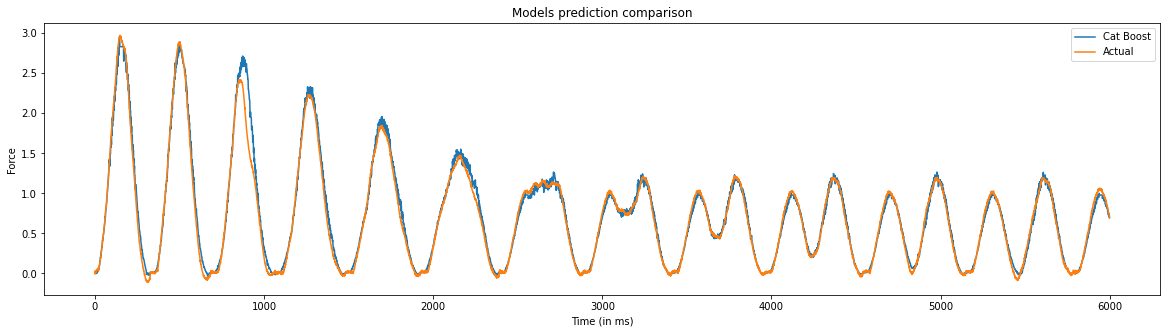

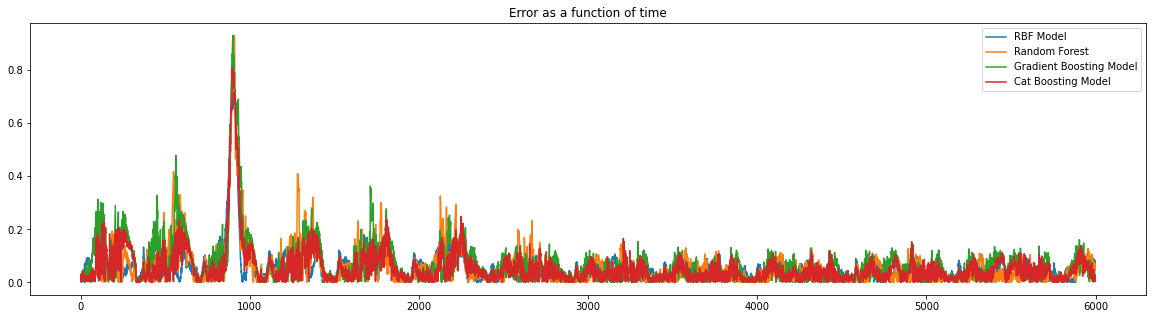

In [21]:
get_results(t=3,m=2)